In [1]:
import numpy as np 
import GPy
import deepgp
import math
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import torch 
import time as timex
import pickle
import pandas as pd
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
colors = sns.color_palette("tab10")
sns.set_palette(colors)
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['legend.loc'] = "upper right"

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure 

def RMSE(y,mean): 
    if type(y) == torch.Tensor:
        y = y.cpu().numpy()
    if type(mean) == torch.Tensor:
        mean = mean.cpu().numpy()
        
    return np.sqrt(((y-mean)**2).mean()).item()

def NLL(y,mean,std):
    if type(y) == torch.Tensor:
        y = y.cpu().numpy()
    if type(mean) == torch.Tensor:
        mean = mean.cpu().numpy()
    if type(std) == torch.Tensor :
        std = std.cpu().numpy()
    return -0.5*((np.log(std**2)+((y-mean)/(std))**2).sum())

In [44]:
#Define the path to the training data
validation_data_path15 = './20201030bag15.pickled'
validation_data_path3  = './20201030bag3.pickled'
training_data_path     = './final_training_data.pickled'

#Loading Traning Data
training_data = pickle.load(open(validation_data_path15, "rb"))
train_x = training_data['features']
y_train = training_data['labels']
train_Fx = y_train[:,0].reshape(-1,1)
train_Fy = y_train[:,1].reshape(-1,1)
train_Fz = y_train[:,2].reshape(-1,1)

#Load test ddata
#In distro
test_data_3 = pickle.load(open(validation_data_path3, "rb"))
test_x = test_data_3['features']
y_test_3 = test_data_3['labels']
time = test_data_3['labels_timestamp']
test_Fx = y_test_3[:,0].squeeze()
test_Fy = y_test_3[:,1].squeeze()
test_Fz = y_test_3[:,2].squeeze()

print(test_x[1,:].reshape(-1,1).T.shape)

#Out distro
test_data_15 = pickle.load(open(validation_data_path15, "rb"))
test_x_out = test_data_15['features']
y_test_15 = test_data_15['labels']
time_out = test_data_15['labels_timestamp']
test_Fx_out = y_test_15[:,0].squeeze()
test_Fy_out = y_test_15[:,1].squeeze()
test_Fz_out = y_test_15[:,2].squeeze()

#Load Baseline
#In distrtibution
GP_pred = np.genfromtxt("../BaselineResults/GP_baseline_bag3.csv", delimiter=',')
baseline_time = np.genfromtxt("../BaselineResults/GP_x_axis_bag3.csv", delimiter=',')

idx_start_baseline = np.argwhere(baseline_time > time[0])[0].item()
idx_stop_baseline = idx_start_baseline + len(time)
print('idx_star_baseline',idx_start_baseline,'-------',idx_stop_baseline)

baseline_time = baseline_time[idx_start_baseline:idx_stop_baseline]

baseline_Fx = GP_pred[idx_start_baseline:idx_stop_baseline,0]
baseline_Fy = GP_pred[idx_start_baseline:idx_stop_baseline,1]
baseline_Fz = GP_pred[idx_start_baseline:idx_stop_baseline,2]

#Out distrtibution
GP_pred = np.genfromtxt("../BaselineResults/GP_baseline_bag15.csv", delimiter=',')
baseline_time_out = np.genfromtxt("../BaselineResults/GP_x_axis_bag15.csv", delimiter=',')

idx_start_baseline = np.argwhere(baseline_time_out > time_out[0])[0].item()
idx_stop_baseline = idx_start_baseline + len(time_out)
print('idx_star_baseline',idx_start_baseline,'-------',idx_stop_baseline)

baseline_time_out = baseline_time_out[idx_start_baseline:idx_stop_baseline]

baseline_Fx_out = GP_pred[idx_start_baseline:idx_stop_baseline,0]
baseline_Fy_out = GP_pred[idx_start_baseline:idx_stop_baseline,1]
baseline_Fz_out = GP_pred[idx_start_baseline:idx_stop_baseline,2]

(1, 6)
idx_star_baseline 949 ------- 5943
idx_star_baseline 1587 ------- 4785


In [7]:
layers1 = [train_Fx.shape[1], train_x.shape[1]]
layers2 = [train_Fx.shape[1], 1, train_x.shape[1]]
layers3 = [train_Fx.shape[1], 1, 1, train_x.shape[1]]
layers4 = [train_Fx.shape[1], 1, 1, 1, train_x.shape[1]]
layers5 = [train_Fx.shape[1], 1, 1, 1, 1, train_x.shape[1]]
layers6 = [train_Fx.shape[1], 1, 1, 1, 1, 1, train_x.shape[1]]
layers7 = [train_Fx.shape[1], 1, 1, 1, 1, 1, train_x.shape[1]]
layers8 = [train_Fx.shape[1], 1, 1, 1, 1, 1, 1, train_x.shape[1]]
layers9 = [train_Fx.shape[1], 1, 1, 1, 1, 1, 1, 1, train_x.shape[1]]
layers10= [train_Fx.shape[1], 1, 1, 1, 1, 1, 1, 1, 1, train_x.shape[1]]


TRAINING_TIMES_X = []
INFERENCE_TIME_X = []
TRAINING_TIMES_Y = []
INFERENCE_TIME_Y = []
TRAINING_TIMES_Z = []
INFERENCE_TIME_Z = []


PREDICTIONS_X = []
STD_X = []
RMSE_X = []
PREDICTIONS_X_OUT = []
STD_X_OUT = []
RMSE_X_OUT = []
PREDICTIONS_Y = []
STD_Y = []
RMSE_Y = []
PREDICTIONS_Y_OUT = []
STD_Y_OUT = []
RMSE_Y_OUT = []
PREDICTIONS_Z = []
STD_Z = []
RMSE_Z = []
PREDICTIONS_Z_OUT = []
STD_Z_OUT = []
RMSE_Z_OUT = []



LAYERS = [layers1,layers2,layers3,layers4,layers5,layers6,layers7,layers8,layers9,layers10]

In [8]:
for layers in LAYERS:
    print('layers',layers)
    inits = ['PCA']*(len(layers)-1)
    kernels = []
    for i in layers[1:]:
        kernels += [GPy.kern.RBF(i)]
    
    mx = deepgp.DeepGP(layers,Y=train_Fx, X=train_x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=50, back_constraint=False)

    mx.initialize_parameter()
    start = timex.time()
    mx.optimize(messages=True,max_iters=100)
    stop = timex.time()
    TRAINING_TIMES_X.append(stop-start)
    start= timex.time()
    _,_ = mx.predict(test_x[1,:].reshape(-1,1).T)
    stop = timex.time()
    INFERENCE_TIME_X.append(stop-start)
    #-----X
    #In distribution performance
    mean_Fx,varx = mx.predict(test_x)
    mean_Fx = mean_Fx.squeeze()
    std_Fx = np.sqrt(varx).squeeze()
    PREDICTIONS_X.append(mean_Fx)
    STD_X.append(std_Fx)
    RMSE_X.append(RMSE(test_Fx,mean_Fx)) 
    #Out of distro performance  
    mean_Fx_out,varx_out = mx.predict(test_x_out)
    mean_Fx_out = mean_Fx_out.squeeze()
    std_Fx_out = np.sqrt(varx_out).squeeze()
    PREDICTIONS_X_OUT.append(mean_Fx_out)
    STD_X_OUT.append(std_Fx_out)
    RMSE_X_OUT.append(RMSE(test_Fx_out,mean_Fx_out)) 

layers [1, 6]


layers [1, 1, 6]


layers [1, 1, 1, 6]


layers [1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 1, 1, 6]


In [9]:
for layers in LAYERS:
    print('layers',layers)
    inits = ['PCA']*(len(layers)-1)
    kernels = []
    for i in layers[1:]:
        kernels += [GPy.kern.RBF(i)]
    
    my = deepgp.DeepGP(layers,Y=train_Fy, X=train_x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=50, back_constraint=False)

    my.initialize_parameter()
    start = timex.time()
    my.optimize(messages=True,max_iters=100)
    stop = timex.time()
    TRAINING_TIMES_Y.append(stop-start)
    start= timex.time()
    _,_ = my.predict(test_x[1,:].reshape(-1,1).T)
    stop = timex.time()
    INFERENCE_TIME_Y.append(stop-start)
    #-----X
    #In distribution performance
    mean_Fy,vary = my.predict(test_x)
    mean_Fy = mean_Fy.squeeze()
    std_Fy = np.sqrt(vary).squeeze()
    PREDICTIONS_Y.append(mean_Fy)
    STD_Y.append(std_Fy)
    RMSE_Y.append(RMSE(test_Fy,mean_Fy)) 
    #Out of distro performance  
    mean_Fy_out,vary_out = my.predict(test_x_out)
    mean_Fy_out = mean_Fy_out.squeeze()
    std_Fy_out = np.sqrt(vary_out).squeeze()
    PREDICTIONS_Y_OUT.append(mean_Fy_out)
    STD_Y_OUT.append(std_Fy_out)
    RMSE_Y_OUT.append(RMSE(test_Fy_out,mean_Fy_out)) 
 

layers [1, 6]


layers [1, 1, 6]


layers [1, 1, 1, 6]


layers [1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 1, 1, 6]


In [10]:
for layers in LAYERS:
    print('layers',layers)
    inits = ['PCA']*(len(layers)-1)
    kernels = []
    for i in layers[1:]:
        kernels += [GPy.kern.RBF(i)]
    
    mz = deepgp.DeepGP(layers,Y=train_Fz, X=train_x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=50, back_constraint=False)

    mz.initialize_parameter()
    start = timex.time()
    mz.optimize(messages=True,max_iters=100)
    stop = timex.time()
    TRAINING_TIMES_Z.append(stop-start)
    start= timex.time()
    _,_ = mz.predict(test_x[1,:].reshape(-1,1).T)
    stop = timex.time()
    INFERENCE_TIME_Z.append(stop-start)
    #-----X
    #In distribution performance
    mean_Fz,varz = mz.predict(test_x)
    mean_Fz = mean_Fz.squeeze()
    std_Fz = np.sqrt(varz).squeeze()
    PREDICTIONS_Z.append(mean_Fz)
    STD_Z.append(std_Fz)
    RMSE_Z.append(RMSE(test_Fz,mean_Fz)) 
    #Out of distro performance  
    mean_Fz_out,varz_out = mz.predict(test_x_out)
    mean_Fz_out = mean_Fz_out.squeeze()
    std_Fz_out = np.sqrt(varz_out).squeeze()
    PREDICTIONS_Z_OUT.append(mean_Fz_out)
    STD_Z_OUT.append(std_Fz_out)
    RMSE_Z_OUT.append(RMSE(test_Fz_out,mean_Fz_out)) 

layers [1, 6]


layers [1, 1, 6]


layers [1, 1, 1, 6]


layers [1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 1, 6]


layers [1, 1, 1, 1, 1, 1, 1, 1, 1, 6]


[6892.6399149006265, -3053.5680500193807, 4376.970178214501, 5288.874034580324, 7523.476552083261, 8778.393044402004, 9033.638443104854, 9041.565949931724, 9153.53872123538, 9042.915803853411]


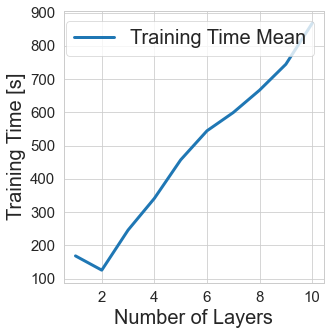

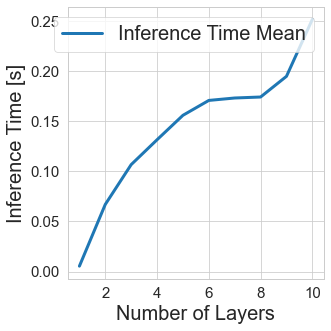

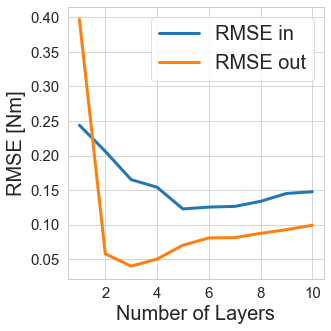

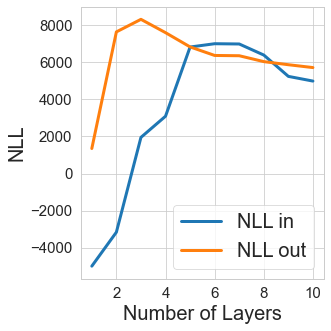

In [68]:
fig1 ,ax1 = plt.subplots(1,1,figsize =(5,5))

TRAINING_TIMES_MEAN = np.sum(np.array([TRAINING_TIMES_X,TRAINING_TIMES_Y,TRAINING_TIMES_Z]).T,-1)
INFERENCE_TIME_MEAN = np.sum(np.array([INFERENCE_TIME_X,INFERENCE_TIME_Y,INFERENCE_TIME_Z]).T,-1)
RMSE_MEAN = np.mean(np.array([RMSE_X,RMSE_Y,RMSE_Z]).T,-1)
RMSE_MEAN_OUT = np.mean(np.array([RMSE_X_OUT,RMSE_Y_OUT,RMSE_Z_OUT]).T,-1)

NLL_X = [NLL(PREDICTIONS_X[i],test_Fx,STD_X[i]) for i in range(0,len(LAYERS))]
NLL_Y = [NLL(PREDICTIONS_Y[i],test_Fy,STD_Y[1])for i in range(0,len(LAYERS))]
NLL_Z = [NLL(PREDICTIONS_Z[i],test_Fz,STD_Z[1])for i in range(0,len(LAYERS))]
NLL_MEAN = np.mean(np.array([NLL_X,NLL_Y,NLL_Z]).T,-1)
NLL_X_OUT = [NLL(PREDICTIONS_X_OUT[i],test_Fx_out,STD_X_OUT[i]) for i in range(0,len(LAYERS))]
NLL_Y_OUT = [NLL(PREDICTIONS_Y_OUT[i],test_Fy_out,STD_Y_OUT[i])for i in range(0,len(LAYERS))]
NLL_Z_OUT = [NLL(PREDICTIONS_Z_OUT[i],test_Fz_out,STD_Z_OUT[i])for i in range(0,len(LAYERS))]
NLL_MEAN_OUT = np.mean(np.array([NLL_X_OUT,NLL_Y_OUT,NLL_Z_OUT]).T,-1)
print(NLL_X)
"""
ax1.plot(range(1,len(LAYERS)+1),TRAINING_TIMES_X,label = 'Training Time X',linewidth = 2)
ax1.plot(range(1,len(LAYERS)+1),TRAINING_TIMES_Y,label = 'Training Time Y',linewidth = 2)
ax1.plot(range(1,len(LAYERS)+1),TRAINING_TIMES_Z,label = 'Training Time Z',linewidth = 2)
"""
ax1.plot(range(1,len(LAYERS)+1),TRAINING_TIMES_MEAN,label = 'Training Time Mean',linewidth = 3)
ax1.set_ylabel('Training Time [s]')
ax1.set_xlabel('Number of Layers')
ax1.legend()

fig2 ,ax2 = plt.subplots(1,1,figsize =(5,5))
"""
ax2.plot(range(1,len(LAYERS)+1),INFERENCE_TIME_X,label = 'Inference Time X',linewidth = 2)
ax2.plot(range(1,len(LAYERS)+1),INFERENCE_TIME_Y,label = 'Inference Time Y',linewidth = 2)
ax2.plot(range(1,len(LAYERS)+1),INFERENCE_TIME_Z,label = 'Inference Time Z',linewidth = 2)
"""
ax2.plot(range(1,len(LAYERS)+1),INFERENCE_TIME_MEAN,label = 'Inference Time Mean',linewidth = 3)
ax2.set_ylabel('Inference Time [s]')
ax2.set_xlabel('Number of Layers')
ax2.legend()

fig3 ,ax3 = plt.subplots(1,1,figsize =(5,5))
"""
ax3.plot(range(1,len(LAYERS)+1),RMSE_X,label = 'X - RMSE in',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_X_OUT,label = 'X - RMSE out',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Y,label = 'Y - RMSE in',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Y_OUT,label = 'Y - RMSE out',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Z,label = 'Z - RMSE in',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Z_OUT,label = 'Z - RMSE out',linewidth = 2)
"""
ax3.plot(range(1,len(LAYERS)+1),RMSE_MEAN,label = 'RMSE in',linewidth = 3)
ax3.plot(range(1,len(LAYERS)+1),RMSE_MEAN_OUT,label = 'RMSE out',linewidth = 3)
ax3.set_ylabel('RMSE [Nm]')
ax3.set_xlabel('Number of Layers')
ax3.legend()

fig4 ,ax4 = plt.subplots(1,1,figsize =(5,5))
"""
ax3.plot(range(1,len(LAYERS)+1),RMSE_X,label = 'X - RMSE in',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_X_OUT,label = 'X - RMSE out',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Y,label = 'Y - RMSE in',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Y_OUT,label = 'Y - RMSE out',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Z,label = 'Z - RMSE in',linewidth = 2)
ax3.plot(range(1,len(LAYERS)+1),RMSE_Z_OUT,label = 'Z - RMSE out',linewidth = 2)
"""
ax4.plot(range(1,len(LAYERS)+1),NLL_MEAN,label = 'NLL in',linewidth = 3)
ax4.plot(range(1,len(LAYERS)+1),NLL_MEAN_OUT,label = 'NLL out',linewidth = 3)
ax4.set_ylabel('NLL')
ax4.set_xlabel('Number of Layers')
ax4.legend(loc = 'lower right')

filename = './LayersInfluenceRealDataTrainingTime.pdf' 
fig1.savefig(filename, format='pdf')
filename = './LayersInfluenceRealDataTestingTime.pdf' 
fig2.savefig(filename, format='pdf')
filename = './LayersInfluenceRealDataRMSE.pdf' 
fig3.savefig(filename, format='pdf')
filename = './LayersInfluenceRealDataNLL.pdf' 
fig4.savefig(filename, format='pdf')

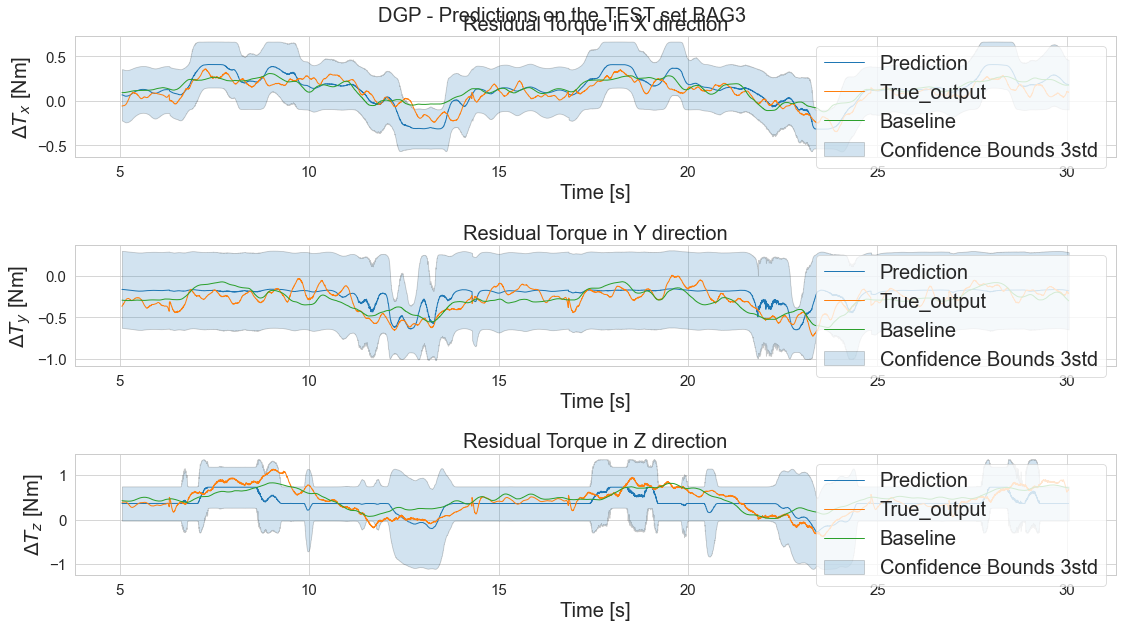

In [62]:
n = 9
mean_Fx = PREDICTIONS_X[n]
std_Fx = STD_X[n]
mean_Fy = PREDICTIONS_Y[n]
std_Fy = STD_Y[n]
mean_Fz = PREDICTIONS_Z[n]
std_Fz = STD_Z[n]


fig , (ax1,ax2,ax3) = plt.subplots(3,1)
#time = np.linspace(0,len(x_test_3),len(x_test_3))
#xlim = None 
plt.suptitle('DGP - Predictions on the TEST set BAG3')
#Plot predictions in Force X 
ax1.set_title('Residual Torque in X direction')
ax1.plot(time,mean_Fx,label='Prediction',linewidth = 1)
ax1.plot(time,test_Fx,label = 'True_output',linewidth = 1)
ax1.plot(baseline_time,baseline_Fx,label = 'Baseline',linewidth = 1)
ax1.fill_between(time,mean_Fx-3*std_Fx,mean_Fx+3*std_Fx, alpha=0.2,label='Confidence Bounds 3std',edgecolor = 'black')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel(r'$\Delta T_x$ [Nm]')
ax1.legend()

#Plot predictions in Fy axis 
ax2.set_title('Residual Torque in Y direction')
ax2.plot(time,mean_Fy,label='Prediction',linewidth = 1 )
ax2.plot(time,test_Fy,label = 'True_output',linewidth = 1 )
ax2.plot(baseline_time,baseline_Fy,label = 'Baseline',linewidth = 1 )
ax2.fill_between(time,mean_Fy-3*std_Fy,mean_Fy+3*std_Fy, alpha=0.2,label='Confidence Bounds 3std',edgecolor = 'black')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel(r'$\Delta T_y$ [Nm]')
ax2.legend()

#Plot predictions in Fz axis 
ax3.set_title('Residual Torque in Z direction')
ax3.plot(time,mean_Fz,label='Prediction',linewidth = 1)
ax3.plot(time,test_Fz,label = 'True_output',linewidth = 1 )
ax3.plot(baseline_time,baseline_Fz,label = 'Baseline',linewidth = 1)
ax3.fill_between(time,mean_Fz-3*std_Fz,mean_Fz+3*std_Fz, alpha=0.2,label='Confidence Bounds 3std',edgecolor = 'black')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel(r'$\Delta T_z$ [Nm]')
ax3.legend()

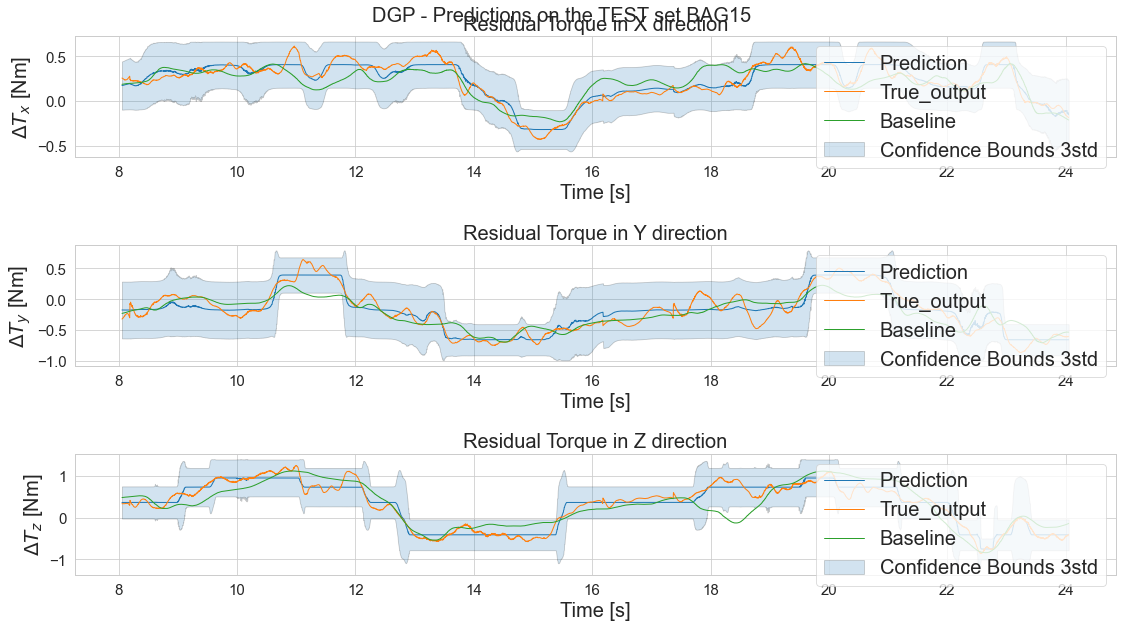

In [63]:
n = 9
mean_Fx_out = PREDICTIONS_X_OUT[n]
std_Fx_out = STD_X_OUT[n]
mean_Fy_out = PREDICTIONS_Y_OUT[n]
std_Fy_out = STD_Y_OUT[n]
mean_Fz_out = PREDICTIONS_Z_OUT[n]
std_Fz_out = STD_Z_OUT[n]


fig , (ax1,ax2,ax3) = plt.subplots(3,1)
#time = np.linspace(0,len(x_test_3),len(x_test_3))
#xlim = None 
plt.suptitle('DGP - Predictions on the TEST set BAG15')
#Plot predictions in Force X 
ax1.set_title('Residual Torque in X direction')
ax1.plot(time_out,mean_Fx_out,label='Prediction',linewidth = 1)
ax1.plot(time_out,test_Fx_out,label = 'True_output',linewidth = 1)
ax1.plot(baseline_time_out,baseline_Fx_out,label = 'Baseline',linewidth = 1)
ax1.fill_between(time_out,mean_Fx_out-3*std_Fx_out,mean_Fx_out+3*std_Fx_out, alpha=0.2,label='Confidence Bounds 3std',edgecolor = 'black')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel(r'$\Delta T_x$ [Nm]')
ax1.legend()

#Plot predictions in Fy axis 
ax2.set_title('Residual Torque in Y direction')
ax2.plot(time_out,mean_Fy_out,label='Prediction',linewidth = 1 )
ax2.plot(time_out,test_Fy_out,label = 'True_output',linewidth = 1 )
ax2.plot(baseline_time_out,baseline_Fy_out,label = 'Baseline',linewidth = 1 )
ax2.fill_between(time_out,mean_Fy_out-3*std_Fy_out,mean_Fy_out+3*std_Fy_out, alpha=0.2,label='Confidence Bounds 3std',edgecolor = 'black')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel(r'$\Delta T_y$ [Nm]')
ax2.legend()

#Plot predictions in Fz axis 
ax3.set_title('Residual Torque in Z direction')
ax3.plot(time_out,mean_Fz_out,label='Prediction',linewidth = 1)
ax3.plot(time_out,test_Fz_out,label = 'True_output',linewidth = 1 )
ax3.plot(baseline_time_out,baseline_Fz_out,label = 'Baseline',linewidth = 1)
ax3.fill_between(time_out,mean_Fz_out-3*std_Fz_out,mean_Fz_out+3*std_Fz_out, alpha=0.2,label='Confidence Bounds 3std',edgecolor = 'black')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel(r'$\Delta T_z$ [Nm]')
ax3.legend()